<a href="https://colab.research.google.com/github/2018007956/HYU/blob/main/Bioinformatics/graph_autoencoder2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Nov 23 05:59:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Environment
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install pytorch-lightning
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 34.6 MB/s 
     |████████████████████████████████| 3.5 MB 65.3 MB/s 
     |████████████████████████████████| 2.4 MB 55.0 MB/s 
     |████████████████████████████████| 709 kB 58.0 MB/s 
     |████████████████████████████████| 467 kB 33.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=ebf6dfd0bbadfb5c2b3c490dded63031ca5a98e977599ef20d041590e02e0196
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/publ

In [ ]:
# Pytorch-lightning datamodule
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader

from torch_geometric.data import Batch
from torch.nn.functional import pad, one_hot
from torch import argmax

class CustomData(LightningDataModule):
  def __init__(self, training_set, validation_set=None, test_set=None, batch_size=128, num_workers=1):
    super().__init__()
    self.training_set = training_set
    self.validation_set = validation_set
    self.test_set = test_set
    self.batch_size = batch_size
    self.num_workers = num_workers
  
  def func1(self, batch): # ZINCDataset
    for data in batch:
      data.x = one_hot(data.x.view(-1,), num_classes=64)
      data.edge_attr = one_hot(data.edge_attr, num_classes=4)
      data.x = data.x.type('torch.FloatTensor')
      data.edge_attr = data.edge_attr.type('torch.FloatTensor')
      data.y = data.y.type('torch.FloatTensor')
    return Batch.from_data_list(batch)

  def func2(self, batch): # TUDataset (Node:원자번호, onehot으로 전처리 됨)
    for data in batch:
      data.x = argmax(data.x, dim=1, keepdim=True) # 다시 원자번호로 바꿔줌 -> argmax: 값이 젤 큰 값의 index 가져옴
      data.x = one_hot(data.x.view(-1,), num_classes=64) # ZINCDataset이랑 모양 똑같아져서 원핫으로 바꿔줌
      data.edge_attr = argmax(data.edge_attr, dim=1)
      data.edge_attr = one_hot(data.edge_attr, num_classes=4)
      data.x = data.x.type('torch.FloatTensor')
      data.edge_attr = data.edge_attr.type('torch.FloatTensor')
      data.y = data.y.type('torch.FloatTensor')
    return Batch.from_data_list(batch)

  def collate_function(self, batch):
    if batch[0].x.size()[1] == 1:
      return self.func1(batch)
    else:
      return self.func2(batch)
    
  def train_dataloader(self):
    if self.training_set is not None:
      return DataLoader(self.training_set, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, collate_fn=self.collate_function)
    else:
      print('The training dataset is empty')
      exit()

  def val_dataloader(self):
    if self.validation_set is not None:
      return DataLoader(self.validation_set, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate_function)
    else:
      print('The validation dataset is empty')
  
  def test_dataloader(self):
    if self.test_set is not None:
      return DataLoader(self.test_set, batch_size=self.batch_size, num_workers=self.num_workers, collate_fn=self.collate_function)
    else:
      print('The test dataset is empty')

In [ ]:
# Pytorch and pytorch-geomtric module
from torch.nn import Module
from torch_geometric.nn import GCNConv

class CustomEncoder(Module):
  def __init__(self, input_size, layer_size=64):
    super().__init__()
    self.input_size = input_size
    self.layer_size = layer_size
    self.setup()

  def setup(self):
    self.first_layer = GCNConv(self.input_size, self.layer_size)
    self.last_layer = GCNConv(self.layer_size, self.layer_size)

  def forward(self, batch):
    z = self.first_layer(batch.x, batch.edge_index)
    z = self.last_layer(z, batch.edge_index)
    return z

In [ ]:
# Pytorch-lightning module
from pytorch_lightning import LightningModule
from torch.optim import Adam
from torch_geometric.nn import global_mean_pool
import torch

class CustomModel(LightningModule):
  def __init__(self, model, learning_rate=1e-3):
    super().__init__()
    self.model = model
    self.lr = learning_rate

  def forward(self, batch, mode):
    z = self.model.encode(batch)
    recon_loss = self.model.recon_loss(z, batch.edge_index)
    kl_loss = 1/batch.batch.size(0) * self.model.kl_loss()
    loss = recon_loss + kl_loss
    self.log(f"{mode}_loss", loss, batch_size=batch.y.size(0), prog_bar=True, on_step=False, on_epoch=True)
    return loss, z, batch.y
  
  def training_step(self, batch, batch_idx):
    loss, predict, answer = self(batch, 'train')
    return {'loss':loss, 'predict':predict, 'answer':answer}

  def validation_step(self, batch, batch_idx):
    loss, predict, answer = self(batch, 'val')
    return {'loss':loss, 'predict':predict, 'answer':answer}

  def predict_step(self, batch, batch_idx):
    z = self.model.encode(batch)
    graph = global_mean_pool(z, batch.batch)
    return graph

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=self.lr)
    return optimizer

In [ ]:
# Pretraining dataset
from torch_geometric.datasets import ZINC
# for ZINC
# x contains atom type
# edge_attr contains bond type

pre_training_dataset = ZINC(root='./ZINC_dataset', subset=True, split='train')
pre_validation_dataset = ZINC(root='./ZINC_dataset', subset=True, split='val')

print(pre_training_dataset)
print(pre_validation_dataset)
print(pre_training_dataset[0])
print(pre_validation_dataset[0])

Extracting ZINC_dataset/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 15687.50it/s]

ZINC(10000)
ZINC(1000)
Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])
Data(x=[35, 1], edge_index=[2, 78], edge_attr=[78], y=[1])



Done!


In [ ]:
# Dataset
from torch_geometric.datasets import TUDataset
# for TUDataset
# x contains atom type represented by one-hot encoding
# edge_attr contains bond type represented by one-hot encoding

training_dataset = TUDataset('./dataset', 'Tox21_AhR_training')
validation_dataset = TUDataset('./dataset', 'Tox21_AhR_testing')
test_dataset = TUDataset('./dataset', 'Tox21_AhR_evaluation')

print(training_dataset)
print(validation_dataset)
print(test_dataset)
print(training_dataset[0])
print(validation_dataset[0])
print(test_dataset[0])

# MORRIS, Christopher, et al. Tudataset: A collection of benchmark datasets for learning with graphs. arXiv preprint arXiv:2007.08663, 2020.

Extracting dataset/Tox21_AhR_training/Tox21_AhR_training.zip
Processing...
Done!
Extracting dataset/Tox21_AhR_testing/Tox21_AhR_testing.zip
Processing...
Done!


Tox21_AhR_training(8169)
Tox21_AhR_testing(272)
Tox21_AhR_evaluation(607)
Data(edge_index=[2, 52], x=[25, 50], edge_attr=[52, 4], y=[1])
Data(edge_index=[2, 44], x=[20, 51], edge_attr=[44, 4], y=[1])
Data(edge_index=[2, 118], x=[53, 53], edge_attr=[118, 4], y=[1])


Extracting dataset/Tox21_AhR_evaluation/Tox21_AhR_evaluation.zip
Processing...
Done!


In [ ]:
# Pretraiing datamodule
predata_module = CustomData(pre_training_dataset, pre_validation_dataset)
for a in predata_module.train_dataloader():
  print(a.x.size())
  print(a.edge_attr.size())
  print(a.edge_index.size())
  print(a.batch.size())
  break

torch.Size([3001, 64])
torch.Size([6472, 4])
torch.Size([2, 6472])
torch.Size([3001])


In [ ]:
# Datamodule
data_module = CustomData(training_dataset, validation_dataset, test_dataset)
for a in data_module.train_dataloader():
  print(a.x.size())
  print(a.edge_attr.size())
  print(a.edge_index.size())
  print(a.batch.size())
  break

torch.Size([2070, 64])
torch.Size([4248, 4])
torch.Size([2, 4248])
torch.Size([2070])


In [ ]:
# Variational graph auto encoder
from torch_geometric.nn import GAE

gae = GAE(CustomEncoder(64))
print(gae)

GAE(
  (encoder): CustomEncoder(
    (first_layer): GCNConv(64, 64)
    (last_layer): GCNConv(64, 64)
  )
  (decoder): InnerProductDecoder()
)


In [ ]:
# Load model
from torch import load
checkpoint = load('./model/zinc_model-v2.ckpt')
checkpoint = checkpoint['state_dict'] # 모델의 상태가 저장된 dictionary만 뽑아옴 어떤 레이어가 어떤 파라미터를 가진다가 저장됨
checkpoint = {k.replace('model.',''):v for k,v in checkpoint.items()} 
gae.load_state_dict(checkpoint) # 파라미터 입혀줌. 학습된 모델의 파라미터와 동일해짐

model = CustomModel(gae)
print(model)

CustomModel(
  (model): GAE(
    (encoder): CustomEncoder(
      (first_layer): GCNConv(64, 64)
      (last_layer): GCNConv(64, 64)
    )
    (decoder): InnerProductDecoder()
  )
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

10000
[0.42779549 0.26651453]


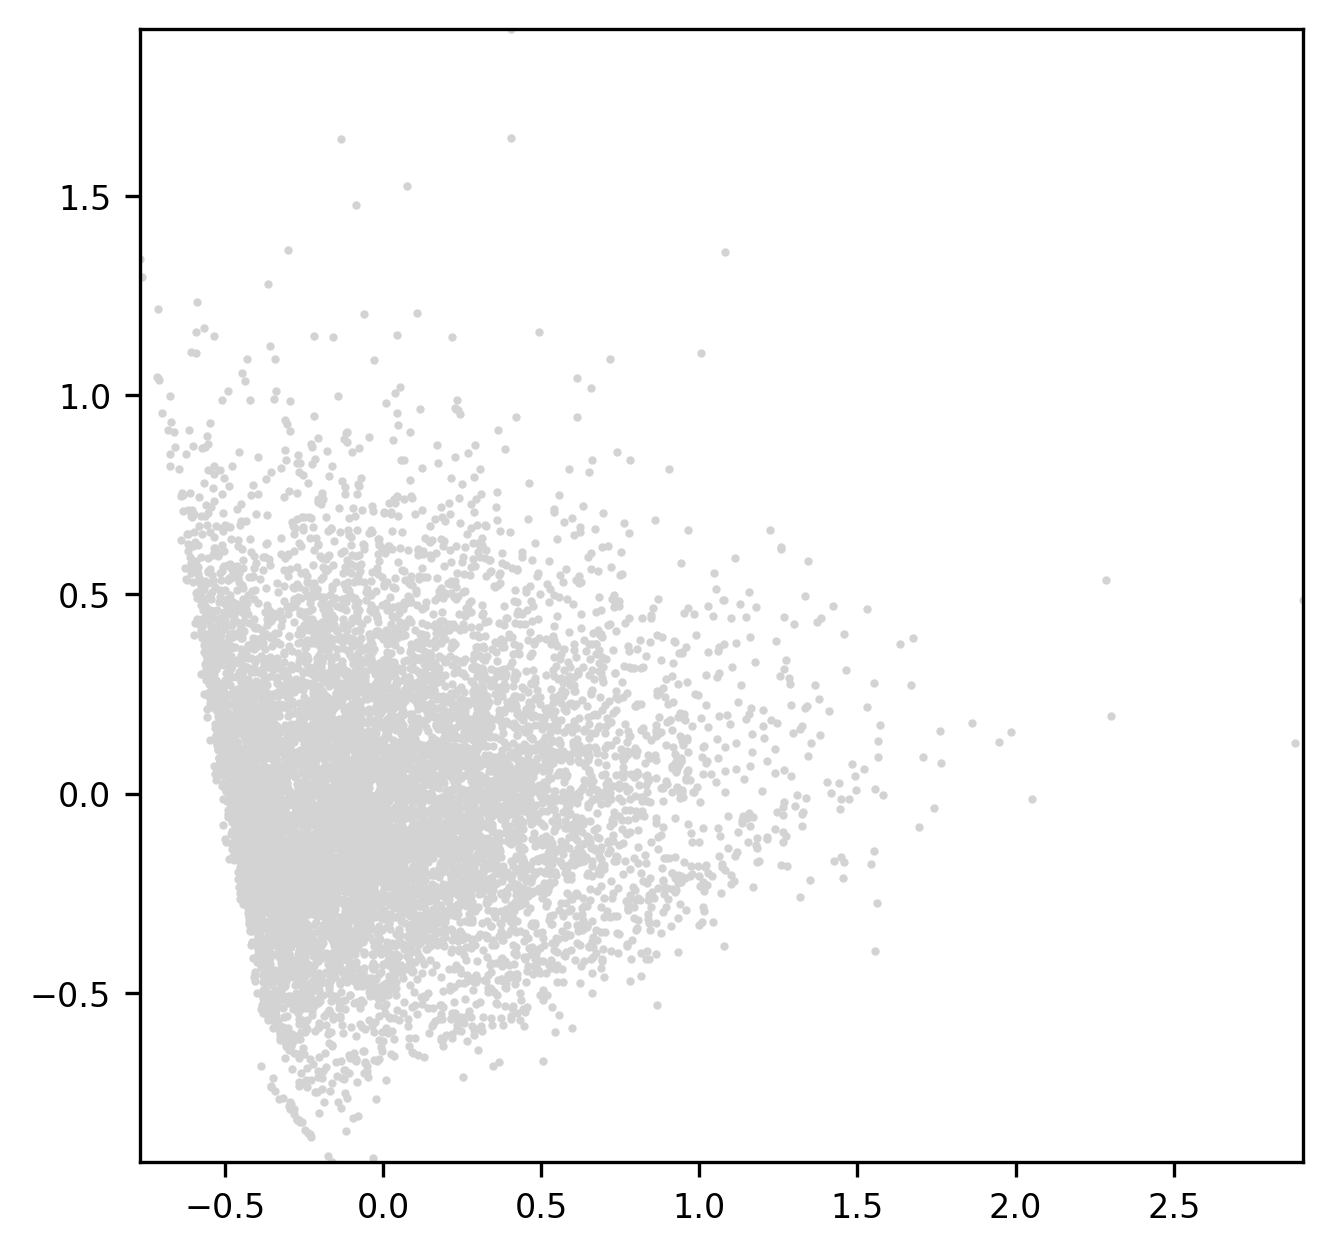

In [ ]:
# Check pretraining
from pytorch_lightning import Trainer

# trainer = Trainer(accelerator='gpu', devices=[0])
trainer = Trainer(accelerator='cpu')

pretrain = trainer.predict(model, dataloaders=predata_module.train_dataloader())
pretrain = torch.concat(pretrain, axis=0)
print(len(pretrain))

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
out = pca.fit_transform(pretrain)
print(pca.explained_variance_ratio_)
zinc_2d = [out[:,idx] for idx in range(2)]

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.set_xlim(zinc_2d[0].min(), zinc_2d[0].max())
ax.set_ylim(zinc_2d[1].min(), zinc_2d[1].max())
marker_size = 4

x = zinc_2d[0]
y = zinc_2d[1]

ax.scatter(x, y, c='lightgrey', s=marker_size, marker=".")

#-> 파라미터 잘 가져옴

In [ ]:
# Predict
from pytorch_lightning import Trainer

# trainer = Trainer(accelerator='gpu', devices=[0])
trainer = Trainer(accelerator='cpu')

train = trainer.predict(model, dataloaders=data_module.train_dataloader())
train = torch.concat(train, axis=0)
print(len(train))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

8169


In [ ]:
# Dimension reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
out = pca.fit_transform(train)
print(pca.explained_variance_ratio_)
tu_2d = [out[:,idx] for idx in range(2)]

[0.58825426 0.19425131]


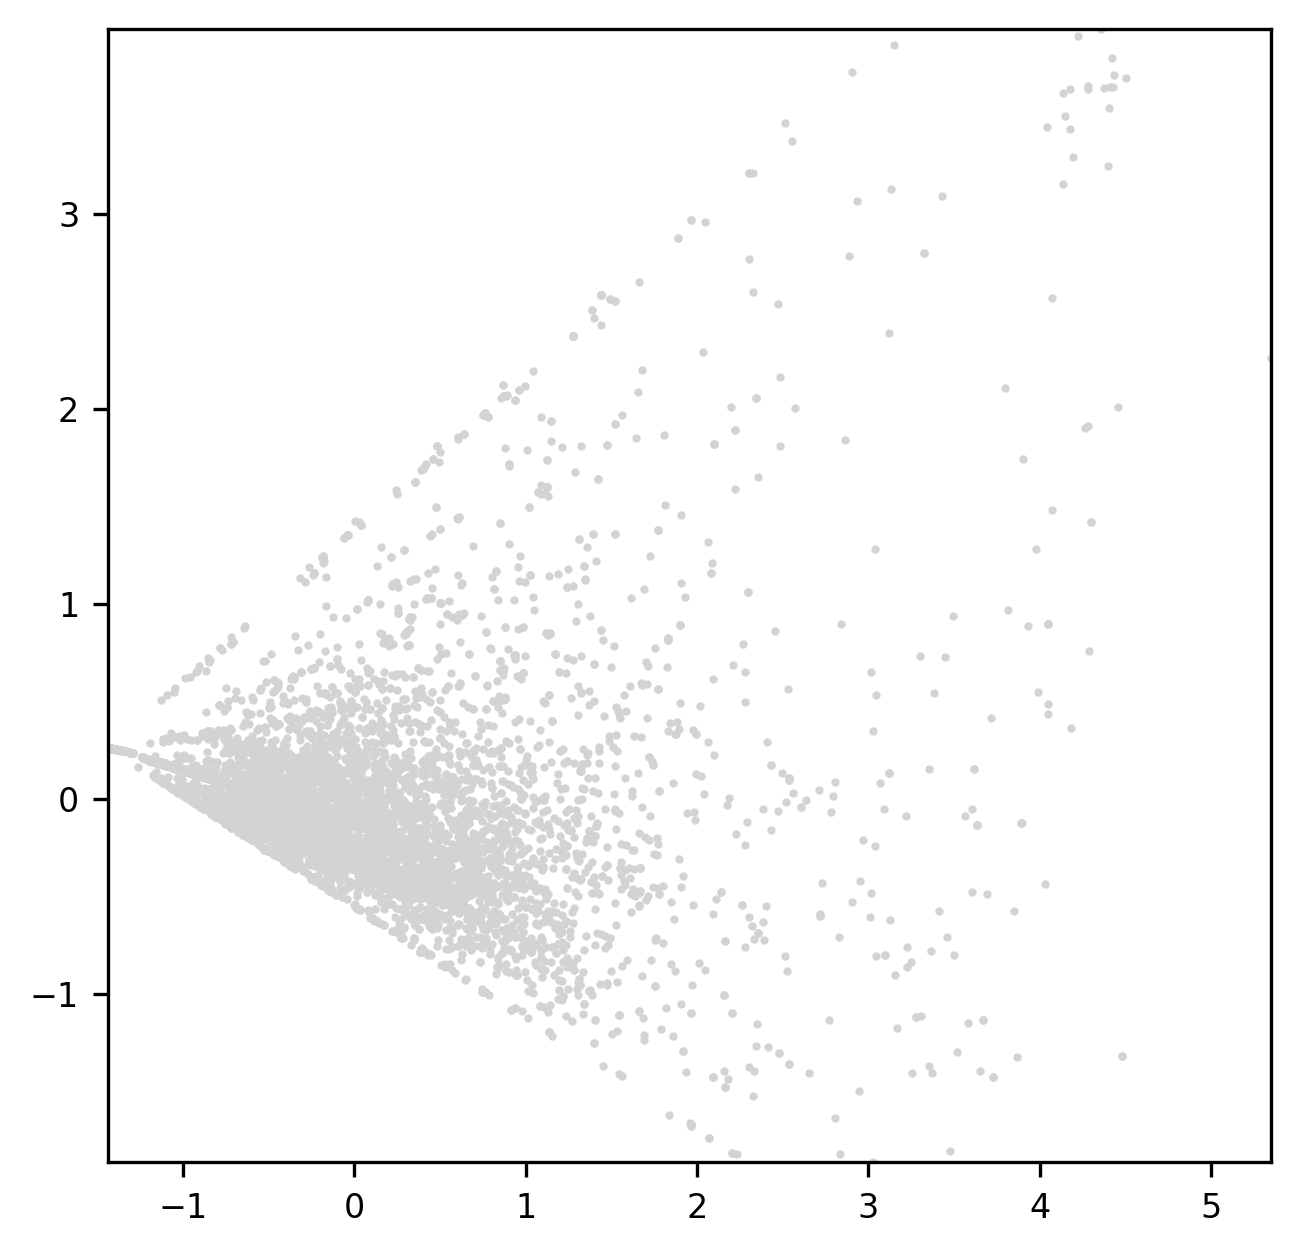

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.set_xlim(tu_2d[0].min(), tu_2d[0].max())
ax.set_ylim(tu_2d[1].min(), tu_2d[1].max())
marker_size = 4

x = tu_2d[0]
y = tu_2d[1]

ax.scatter(x, y, c='lightgrey', s=marker_size, marker=".")

# 같은 인코더를 거쳐도 분포 다르게 나옴

In [ ]:
# 둘 사이 차이 비교

# Combining data
import numpy as np
new_data = np.concatenate((pretrain, train)) # predict한 데이터를 가져와서 합쳐줌 
  # len(pretrain)=10000, len(train) 8169
  # len(new_data)=18169

# 같이 차원 축소
# Dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
out = pca.fit_transform(new_data)
print(pca.explained_variance_ratio_)
new_2d = [out[:,idx] for idx in range(2)]

import pandas as pd
df = pd.DataFrame()
df['x1'] = new_2d[0]
df['x2'] = new_2d[1]
df['label'] = ['zinc'] * len(pretrain) + ['tu'] * len(train)
df

[0.8660234  0.06383307]


,x1,x2,label
0,-1.415223,-0.346055,zinc
1,-1.895205,0.539918,zinc
2,-1.286461,-0.228816,zinc
3,-1.913929,-0.363320,zinc
4,-0.992290,0.275584,zinc
...,...,...,...
18164,1.943691,0.383046,tu
18165,2.064158,-0.238410,tu
18166,1.824445,-0.210743,tu
18167,1.182247,0.008159,tu


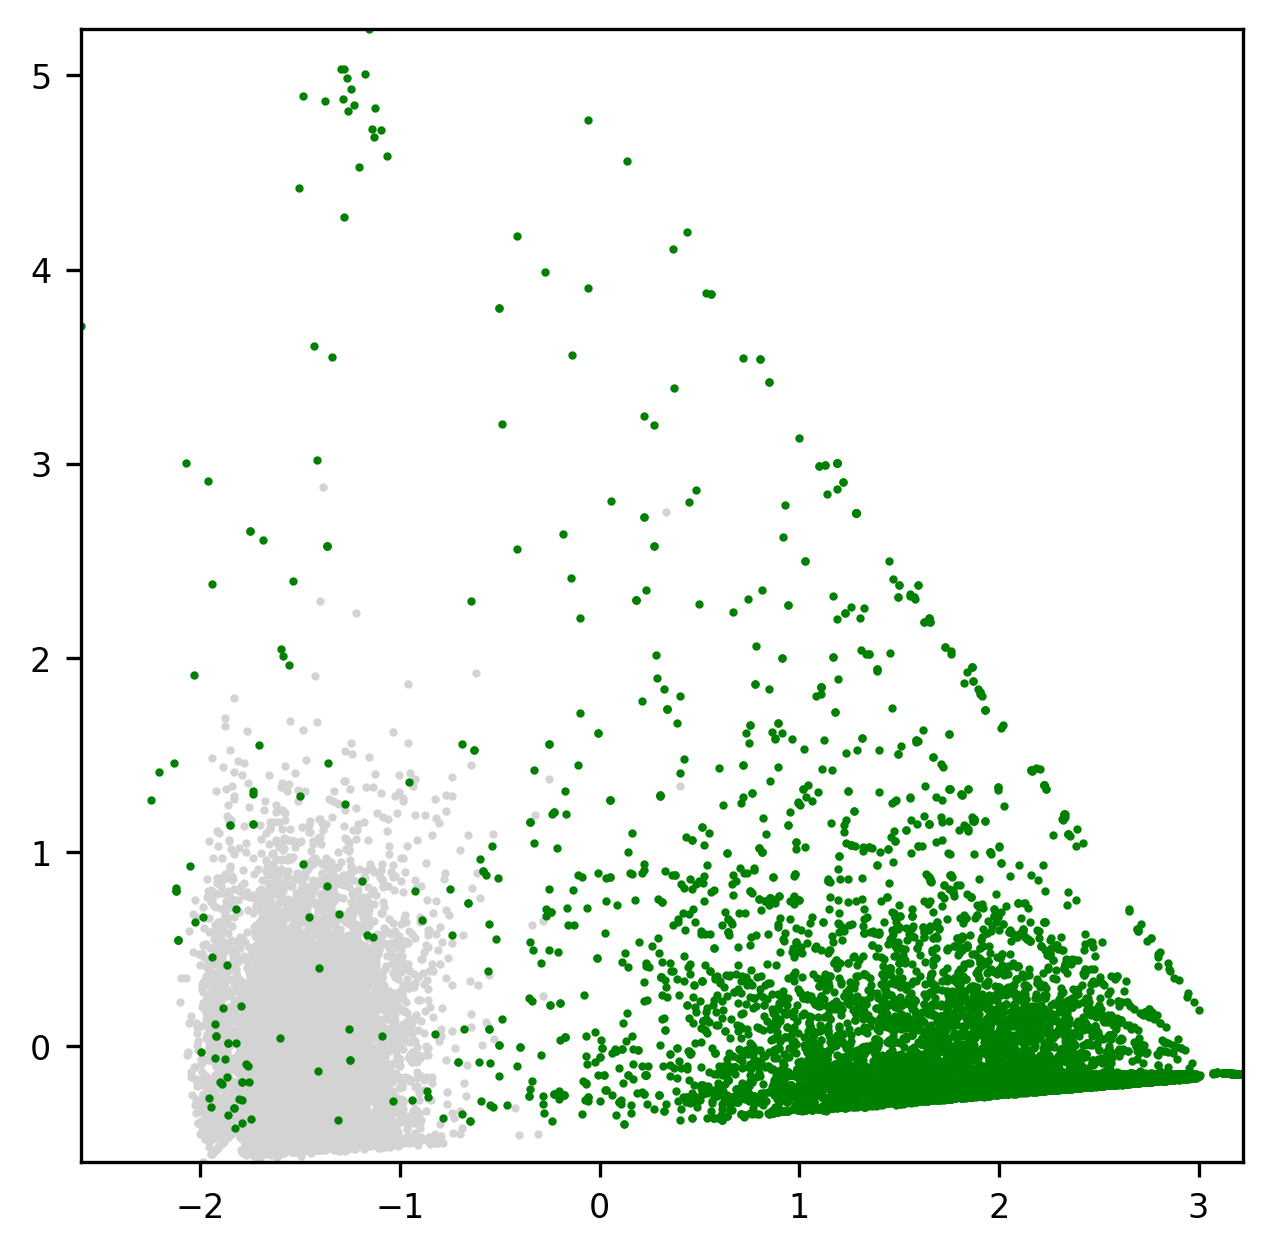

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.set_xlim(df['x1'].min(), df['x1'].max())
ax.set_ylim(df['x2'].min(), df['x2'].max())
marker_size = 4

x = df[df['label'] == 'zinc']['x1']
y = df[df['label'] == 'zinc']['x2']
ax.scatter(x, y, c='lightgrey', s=marker_size, marker=".")

x = df[df['label'] == 'tu']['x1']
y = df[df['label'] == 'tu']['x2']
ax.scatter(x, y, c='green', s=marker_size, marker=".")